In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

In [ ]:
# Import data
data = pd.read_csv("breast cancer.csv")
print(data.head())
print(data.info())
print(data["diagnosis"].unique())


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

In [ ]:
# Extract calssification target
target = data.loc[:, "diagnosis"]
# Convert the target variable to a binary representation (0 or 1)
target = (target == "M").astype(int)
# Extract all other columns except 'diagnosis' as predictors
data_predictors = data.loc[:, data.columns != 'diagnosis']
# Create a list of predictor names
predictor_names = data_predictors.columns

In [ ]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(data_predictors, target, test_size=0.3,random_state=0)

In [ ]:
def generate_random_individuals(population_size, num_features, min_features, max_features):
    individuals = np.zeros((population_size, num_features))
    for i in range(population_size):
        num_ones = np.random.randint(min_features, max_features+1)
        ones_indices = np.random.choice(num_features, num_ones, replace=False)
        individuals[i, ones_indices] = 1
    return individuals

In [ ]:
# 2.& 3.: Train model and get precision
def train_model(x_train, x_test, y_train, y_test, predictor_names):
    x_train = x_train.loc[:, predictor_names]
    x_test = x_test.loc[:, predictor_names]

    #Building the random forest model
    mdl = RandomForestClassifier(random_state=1) #Creating the Random Forest Classifier Model
    mdl.fit(x_train, y_train)                    #Training the Model with x_train & y_train
    y_hat = mdl.predict(x_test)                  #Predicting the x_test
    prec = precision_score(y_test, y_hat)        #Precision: The best value is 1 and the worst value is 0.
    return prec

In [ ]:
def choose_parents(population,accuracy,elite_percent):
    # Get elite of top 2 which doesn't mutate
    elite_num = int(round(((elite_percent*population.shape[0]) // 2) * 2))
    ind_ac = np.argsort(-accuracy)
    top_perc = ind_ac[:elite_num]
    elite_population = population[top_perc,:]   # We should keep this elite

    # Normalize accuracy to obtain weights for roulette wheel selection
    weight_norm = accuracy / accuracy.sum()     # calculate normalised weight from accuracy
    weight_comu = weight_norm.cumsum()          # calc cumulative weight from accuracy

    # Roulette wheel selection
    num_parents_wo_elite = population.shape[0] - elite_num
    parents_wo_elite = np.empty([num_parents_wo_elite,population.shape[1]])
    for count in range(num_parents_wo_elite):
        b = weight_comu[-1]                         # current last element of weight_comu
        rand_num = np.random.uniform(0,b)         # random foating-point number btw 0 and current max weight_comu

        indices = np.searchsorted(weight_comu,rand_num) # get indices of the number in weight_comu greater than rand_num
        parents_wo_elite[count,:] = population[indices, :]

    parents = np.concatenate((elite_population, parents_wo_elite), axis=0)  # Concatenate elite and parents_wo_elite to get all parents
    return parents

In [ ]:
def one_point_crossover(parents,elite_percent,mutation_probability,min_features, max_features):
    elite_num = int(round(((elite_percent*population.shape[0]) // 2) * 2))
    crossover_population = np.zeros((parents.shape[0],parents.shape[1]))         # first two are elite
    crossover_population[0:elite_num,:] = parents[0:elite_num,:]

    for ii in range(int((parents.shape[0]-elite_num)/2)):
        n = 2*ii+elite_num                    # gives even number
        parents_couple = parents[n:n+2, :]    # comb of parents
        b2 = parents.shape[1]                 # num of features
        rand_n = np.random.randint(1, b2-1)   # generate rand number from 1 to num_of_features-1
        crossover_population[n,:] = np.concatenate([parents_couple[0, :rand_n], parents_couple[1, rand_n:]])
        crossover_population[n+1,:] = np.concatenate([parents_couple[1, :rand_n], parents_couple[0, rand_n:]])

    #check if every child has minimum number of features or all true values
    for kk in range(crossover_population.shape[0]):
        Sum = np.sum(crossover_population[kk,:])
        if Sum > max_features:
            # if the number of 1s is bigger than max number of features
            excess = int(Sum - max_features)
            indices = np.where(crossover_population[kk,:] == 1)[0]
            position1 = np.random.choice(indices, size=excess, replace=False)
            crossover_population[kk, position1] = 0 # put 0s in random positions
        elif Sum < min_features:
            # if the number of 1s is smaller than min number of features
            missing = int(min_features - Sum)
            indices = np.where(crossover_population[kk,:] == 0)[0]
            position2 = np.random.choice(indices, size=missing, replace=False)
            crossover_population[kk, position2] = 1 # put 1s in random positions

    # mutation
    child_row = crossover_population.shape[0]
    child_col = crossover_population.shape[1]
    num_mutations = round(child_row*child_col*mutation_probability)
    for jj in range(num_mutations):
        ind_row = np.random.randint(0,child_row) # random number btw 0 and num of rows
        ind_col = np.random.randint(0,child_col) # random number btw 0 and num of colmns
        if (crossover_population[ind_row,ind_col] == 0 and
            np.sum(crossover_population[ind_row,:]) < max_features):
            crossover_population[ind_row,ind_col] = 1
        elif (crossover_population[ind_row,ind_col] == 1 and
              np.sum(crossover_population[ind_row,:]) >= min_features+1):
            crossover_population[ind_row,ind_col] = 0

    return crossover_population

In [ ]:
# Hyperparameters
num_features = data_predictors.shape[1]
min_features = 2            # minimal number of features in a subset of features
population_size = 8         # size of population (number of instances)
max_iterations = 8          # maximum number of iterations
elite_percent = 0.4         # percentage of elite population which doesn't mutate
mutation_probability = 0.2  # percentage of total genes that mutate
max_features = 4            # maximum number of features in a subset of features

In [ ]:
# Main loop - gen 0
#1&2 generate population
population = generate_random_individuals(population_size, num_features, min_features, max_features)
#3&4 train model
accuracy = np.zeros(population_size);
predictor_names = data_predictors.columns
response_name = target.name
for i in range(population_size):
    predictor_names_i = predictor_names[population[i,:]==1]
    accuracy_i = train_model(x_train,x_test,y_train,y_test,predictor_names_i)
    accuracy[i] = accuracy_i
gen = 0
best_acc_i = np.zeros(max_iterations)
best_acc_i[gen] = max(accuracy)     # keep best accuracy from 1st gen

In [ ]:
# Main loop - gen > 0
while gen < max_iterations-1:
    print('Begin iteration num {}/{}'.format(gen+2,max_iterations))
    gen += 1
    parents = choose_parents(population, accuracy, elite_percent)
    children = one_point_crossover(parents,elite_percent,mutation_probability,min_features,max_features)
    population = children
    for ind in range(population_size):
        predictor_names_ind = predictor_names[population[ind,:]==1]
        accuracy_ind = train_model(x_train,x_test,y_train,y_test,predictor_names_ind)
        accuracy[ind] = accuracy_ind
    best_acc_i[gen] = max(accuracy)

ind_max_acc = np.argmax(accuracy)
best_features = population[ind_max_acc,:]

Begin iteration num 5/8
Begin iteration num 6/8
Begin iteration num 7/8
Begin iteration num 8/8


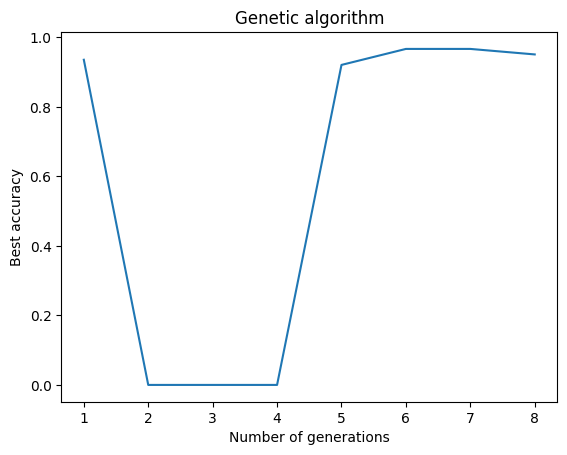

In [ ]:
# Plots - Post-processing
best_features_names = predictor_names[best_features==1]
plt.plot(range(1, max_iterations + 1), best_acc_i)
plt.xlabel('Number of generations')
plt.ylabel('Best accuracy')
plt.title('Genetic algorithm')
plt.show()